# Задание
Данные получены NASA в серии аэродинамических и акустический испытаний профиля сечения лопаток в аэродинамической трубе. 

1) Постройте модель линейной и квантильной регрессии. Проверьте выполнение регрессионных предположений. 

2) Выберете набор независимых переменных и постройте прогноз значения зависимой переменной для двух моделей вместе с доверительными интервалами для прогнозируемых значений.


In [1]:
df <- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat")

In [2]:
colnames(df) <-  c('frequency',         # 1. Частота, Гц.
                    'angle',            # 2. Угол атаки, градусы.
                    'chord_length',     # 3. Длина хорды профиля лопатки, м.
                    'fs_velocity',      # 4. Скорость набегающего потока, м/с.
                    'ssd_thickness',    # 5. Толщина вытеснения на выпуклой стороне (спинке) лопатки, м.
                    'sound_level')      # 6. Уровень громкости, дБ.

In [3]:
head(df)

frequency,angle,chord_length,fs_velocity,ssd_thickness,sound_level
800,0,0.3048,71.3,0.00266337,126.201
1000,0,0.3048,71.3,0.00266337,125.201
1250,0,0.3048,71.3,0.00266337,125.951
1600,0,0.3048,71.3,0.00266337,127.591
2000,0,0.3048,71.3,0.00266337,127.461
2500,0,0.3048,71.3,0.00266337,125.571


# Линейная регрессия
Проверим линейную зависимость уровня громкости от остальных факторов. Сначала проверим коррелированность факторов.

In [4]:
correlations <- as.data.frame(as.table(cor(df[,c('frequency',     
                                                'angle',        
                                                'chord_length', 
                                                'fs_velocity',  
                                                'ssd_thickness')])))

In [5]:
correlations <- correlations[correlations$Var1 != correlations$Var2,]
correlations <- correlations[abs(correlations$Freq) > 0.5, ]

In [6]:
correlations

,Var1,Var2,Freq
8,chord_length,angle,-0.5048681
10,ssd_thickness,angle,0.7533938
12,angle,chord_length,-0.5048681
22,angle,ssd_thickness,0.7533938


Как видно угол атаки сильно коррелирует с толщиной вытеснения на выпуклой стороне и с длинной хорды, поэтому исключим его.

In [7]:
df <- df[,c('frequency',           
            'chord_length', 
            'fs_velocity',  
            'ssd_thickness',
            'sound_level')]

In [8]:
linear_model <- lm(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df)

In [9]:
summary(linear_model)


Call:
lm(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.866  -3.109  -0.018   3.332  15.932 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.304e+02  5.131e-01  254.03   <2e-16 ***
frequency     -1.174e-03  4.246e-05  -27.64   <2e-16 ***
chord_length  -2.597e+01  1.414e+00  -18.36   <2e-16 ***
fs_velocity    8.686e-02  8.351e-03   10.40   <2e-16 ***
ssd_thickness -2.692e+02  1.034e+01  -26.02   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.993 on 1498 degrees of freedom
Multiple R-squared:  0.4776,	Adjusted R-squared:  0.4763 
F-statistic: 342.4 on 4 and 1498 DF,  p-value: < 2.2e-16


Как видно имеется линейгая зависимость, поскольку 

1) Все коэффициенты линейной регрессии являются значимыми при уровне значимости 0.05. 

2) Также коэффициент $R^2$ значительно больше 0. 

3) При уровне значимости 0.05 нулевая гипотеза о равенстве коэффициентов нулю может быть отвергнута по Критерию Фишера поскольку p-value значительно меньше 0.05.

## Линейная регрессия: прогноз
Поскольку все вакторы имеют численный тип, то в качестве точки для прогноза можно выбрать точку со средним значением по каждому из факторов.

In [10]:
newdf <- as.data.frame.list(colMeans(df))
newdf

frequency,chord_length,fs_velocity,ssd_thickness,sound_level
2886.381,0.1365482,50.86075,0.01113988,124.8359


Перед построением прогноза необходимо убедиться, что остатки распределены согласно нормальному закону.

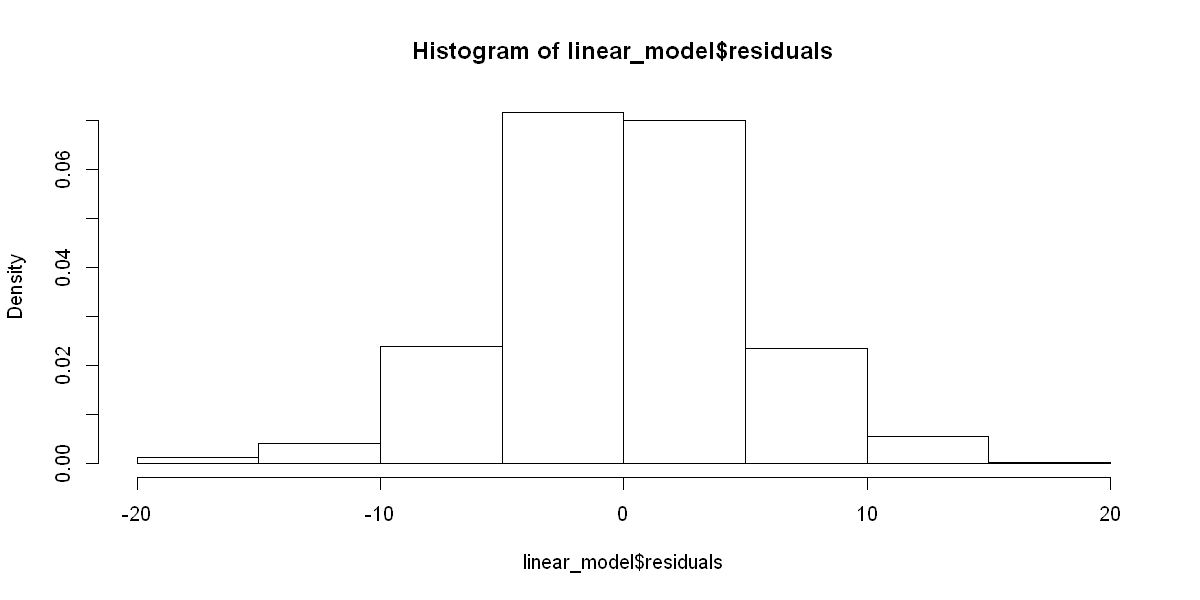

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
hist(linear_model$residuals, probability = T)

In [12]:
shapiro.test(linear_model$residuals)


	Shapiro-Wilk normality test

data:  linear_model$residuals
W = 0.9939, p-value = 7.58e-06


К сожалению, при уровне значимости 0.05 согласно критерию Шапиро-Уилка гипотеза о нормальности должна быть отвергнута.  Построение доверительных иннтервалов является не совсем корректным. Возможно следует произвести предварительну обработку данных.

Построим прогноз с доверительным 95% интервалом для выбранной точки.

In [13]:
predict(linear_model, newdf, interval="predict") 

,fit,lwr,upr
1,124.8359,115.0395,134.6324


# Квантильная регрессия

In [17]:
library("quantreg")

Аналогично потсроим зависимости для квнтильной регрессии с квантилями 0.25, 0.5 и 0.75.

In [28]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df, tau=0.25)
summary(quantile_model)


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, tau = 0.25, data = df)

tau: [1] 0.25

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    127.43380    0.65252  195.29354    0.00000
frequency       -0.00145    0.00004  -34.60381    0.00000
chord_length   -20.74500    1.68472  -12.31360    0.00000
fs_velocity      0.09021    0.00900   10.02234    0.00000
ssd_thickness -291.93891    6.56122  -44.49463    0.00000

In [29]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df, tau=0.5)
summary(quantile_model)


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, tau = 0.5, data = df)

tau: [1] 0.5

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    131.83935    0.58836  224.08065    0.00000
frequency       -0.00148    0.00005  -28.17041    0.00000
chord_length   -29.39741    1.45549  -20.19761    0.00000
fs_velocity      0.09031    0.00913    9.89034    0.00000
ssd_thickness -303.96960   16.78941  -18.10484    0.00000

In [30]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df, tau=0.75)
summary(quantile_model)


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, tau = 0.75, data = df)

tau: [1] 0.75

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    136.04258    0.71844  189.35785    0.00000
frequency       -0.00134    0.00010  -14.04119    0.00000
chord_length   -35.46116    1.87154  -18.94758    0.00000
fs_velocity      0.07373    0.01058    6.97015    0.00000
ssd_thickness -277.47876   14.28888  -19.41920    0.00000

Во всех случаях коэффициенты регрессии значимы. Заметим также, что для разных квантилей мы получили разные зависимости. То есть для лопаток с высоким уровнем шума и для лопаток с низким уровнем шума зависисмость от факторов различна.

## Квантильная регрессия: прогноз

Аналогично линейной регрессии построим прогноз для квантильной регрессии с квантилем 0.75

In [32]:
newdf <- as.data.frame.list(colMeans(df))
newdf

frequency,chord_length,fs_velocity,ssd_thickness,sound_level
2886.381,0.1365482,50.86075,0.01113988,124.8359


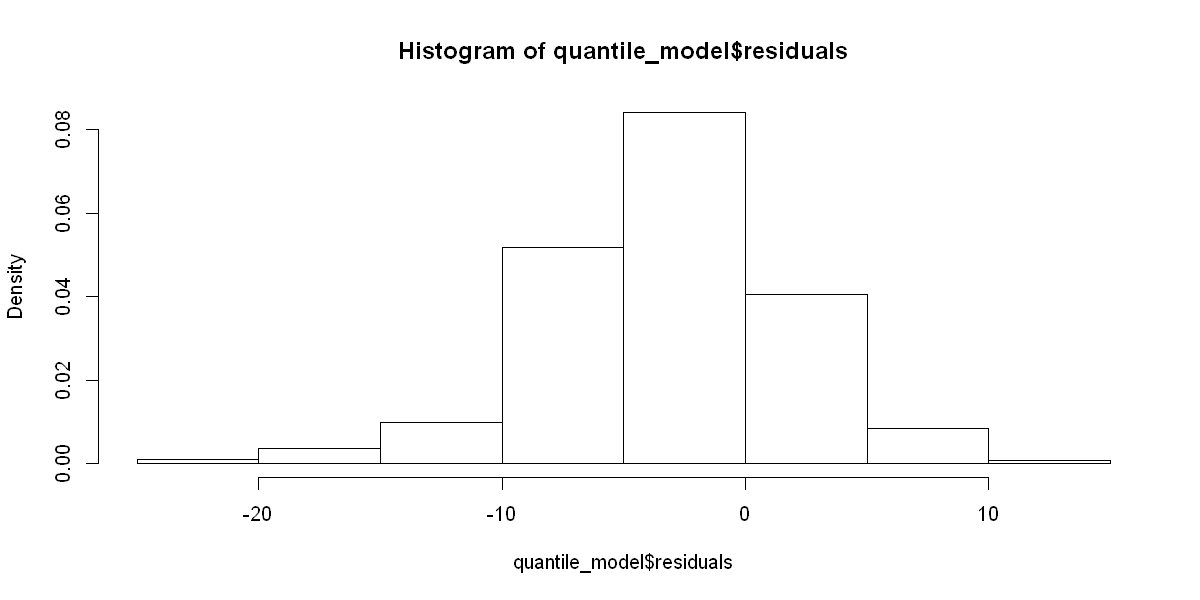

In [31]:
hist(quantile_model$residuals, probability = T)

In [33]:
shapiro.test(quantile_model$residuals)


	Shapiro-Wilk normality test

data:  quantile_model$residuals
W = 0.986, p-value = 7.024e-11


Нормальности остатков по-пре

In [36]:
predict(quantile_model, newdf, interval=c("confidence")) 

,fit,lower,higher
1,127.9901,127.5902,128.3899
